In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_grid_coordinates(coords):
    return np.floor(coords).astype("int")


def modified_poisson_disk_sampling(N=100, r0=10, r_sigma=1, k=50):
    """
    Implementation of the Poisson Disk Sampling algorithm, but modified so that for each
    point added the radius between points is sampled from a Gaussian distribution

    :param N: grid size in number of pixels (assumed square domain)
    :param r0: length-scale for distance between points
    :param r_sigma: std div for distance between points
    :param k: Number of iterations to find a new particle in an annulus between radius r and 2r from a sample particle.
    :return: nParticle: Number of particles in the sampling.
             particleCoordinates: 2d array containing the coordinates of the created particles.
             radii: radii for the sampled particles

    based on https://gitlab.com/abittner/poissondisksampling/-/blob/master/poissonDiskSampling/bridsonVariableRadius.py
    """

    def _gen_radius():
        return np.random.normal(r0, r_sigma)

    # Set-up background grid
    gridHeight = gridWidth = N
    grid = np.zeros((gridHeight, gridWidth))

    # Pick initial (active) point
    coords = (np.random.random() * gridHeight, np.random.random() * gridWidth)
    idx = get_grid_coordinates(coords)
    nParticle = 1
    grid[idx[0], idx[1]] = nParticle

    # Initialise active queue
    # Appending to list is much quicker than to numpy array, if you do it very often
    queue = [coords]
    # List containing the exact positions of the final particles
    particleCoordinates = [coords]
    radii = [_gen_radius()]
    activeRadii = [radii[0]]

    # Continue iteration while there is still points in active list
    while queue:

        # Pick random element in active queue
        idx = np.random.randint(len(queue))
        r_active = activeRadii[idx]
        activeCoords = queue[idx]
        # activeGridCoords = get_grid_coordinates(activeCoords)

        success = False
        for _ in range(k):

            # Pick the angle to the sample particle and determine its coordinates
            angle = 2 * np.pi * np.random.random()
            newCoords = np.zeros(2)
            newCoords[0] = activeCoords[0] + 2 * r_active * np.sin(angle)
            newCoords[1] = activeCoords[1] + 2 * r_active * np.cos(angle)

            # Prevent that the new particle is outside of the grid
            if not (0 <= newCoords[1] <= gridWidth and 0 <= newCoords[0] <= gridHeight):
                continue

            # Check that particle is not too close to other particle
            newGridCoords = get_grid_coordinates((newCoords[1], newCoords[0]))

            radiusThere = _gen_radius()
            gridRangeX = (
                np.max([newGridCoords[0] - radiusThere, 0]).astype("int"),
                np.min([newGridCoords[0] + radiusThere + 1, gridWidth]).astype("int"),
            )
            gridRangeY = (
                np.max([newGridCoords[1] - radiusThere, 0]).astype("int"),
                np.min([newGridCoords[1] + radiusThere + 1, gridHeight]).astype("int"),
            )

            searchGrid = grid[
                slice(gridRangeY[0], gridRangeY[1]), slice(gridRangeX[0], gridRangeX[1])
            ]
            conflicts = np.where(searchGrid > 0)

            if len(conflicts[0]) == 0 and len(conflicts[1]) == 0:
                # No conflicts detected. Create a new particle at this position!
                queue.append(newCoords)
                activeRadii.append(radiusThere)
                radii.append(radiusThere)
                particleCoordinates.append(newCoords)
                nParticle += 1
                grid[newGridCoords[1], newGridCoords[0]] = nParticle
                success = True

            else:
                # There is a conflict. Do NOT create a new particle at this position!
                continue

        if success == False:
            # No new particle could be associated to the currently active particle.
            # Remove current particle from the active queue!
            del queue[idx]
            del activeRadii[idx]

    return (nParticle, np.array(particleCoordinates), np.array(radii))

(31, 100.03206221534985, 1.0884224881279798)

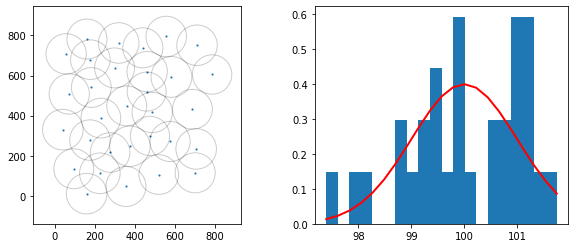

In [4]:
r0 = 100
r_sigma = 1.0
n_pts, pts, radii = modified_poisson_disk_sampling(N=800, r0=r0, r_sigma=r_sigma)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
ax = axes[0]
ax.scatter(pts[:, 0], pts[:, 1], marker=".", s=5)
for i in range(pts.shape[0]):
    ax.add_patch(
        plt.Circle(
            xy=pts[i, :],
            radius=radii[i],
            facecolor="none",
            edgecolor="black",
            alpha=0.2,
        )
    )
ax.set_aspect(1)

ax = axes[1]

count, bins, ignored = ax.hist(radii, 20, density=True)
ax.plot(
    bins,
    1
    / (r_sigma * np.sqrt(2 * np.pi))
    * np.exp(-((bins - r0) ** 2) / (2 * r_sigma**2)),
    linewidth=2,
    color="r",
)

n_pts, np.mean(radii), np.std(radii)

In [5]:
def make_gaussian_2d(x_center=0, y_center=0, theta=0, sigma_x=10, sigma_y=10):
    """
    Return a function of `(x, y)` that evaluates the value of a 2D Gaussian distribution centered on `(x_center, y_center)` and std.div. in x- and y-directions `sigma_x` and `sigma_y` rotated by angle `theta`
    in degrees
    """
    # x_center and y_center will be the center of the gaussian, theta will be the rotation angle
    # sigma_x and sigma_y will be the stdevs in the x and y axis before rotation
    # x_size and y_size give the size of the frame
    sx = sigma_x
    sy = sigma_y
    x0 = x_center
    y0 = y_center

    theta = theta * np.pi / 180

    def fn(x, y):
        a = np.cos(theta) * x - np.sin(theta) * y
        b = np.sin(theta) * x + np.cos(theta) * y
        a0 = np.cos(theta) * x0 - np.sin(theta) * y0
        b0 = np.sin(theta) * x0 + np.cos(theta) * y0

        return np.exp(
            -(((a - a0) ** 2) / (2 * (sx**2)) + ((b - b0) ** 2) / (2 * (sy**2)))
        )

    return fn


def make_carrier_wave_2d(theta, lw):
    """
    Return function of `(x,y)` which evaluates the amplitude of a plane-parallel sinosoidal with wavelength `lw` and orientation angle `theta` (in degrees)
    """
    theta = theta * np.pi / 180

    def fn(x, y):
        x_ = np.cos(theta) * x - np.sin(theta) * y
        return np.cos(2 * np.pi / lw * x_)

    return fn

In [6]:
def make_2d_wavepacket(x0, y0, lx, ly, theta, lw):
    """
    Return a function of `(x,y)` which produces the amplitude of a plane-parallel sinosoidal wave with wavelength `lw` and orientation angle `theta` modulated by a 2D Gaussian envelope centered on `(x0, y0)` of characteristic widths `(lx, ly)`
    oriented with width `lx` along the direction angle `theta`.

    In summary:
        (x0, y0): position of wavepacket
        (lx, ly): x- and y- length-scale of wavepacket
        theta: orientation of wavepacket and sinosoidal carrier wave [deg]
        lw: length-scale of gravity "carrier wave"
    """
    fn_envelope = make_gaussian_2d(
        x_center=x0, y_center=y0, theta=theta, sigma_x=lx / 2, sigma_y=ly / 2
    )
    fn_carrier = make_carrier_wave_2d(theta=theta, lw=lw)

    def fn(x, y):
        return fn_envelope(x, y) * fn_carrier(x, y)

    return fn

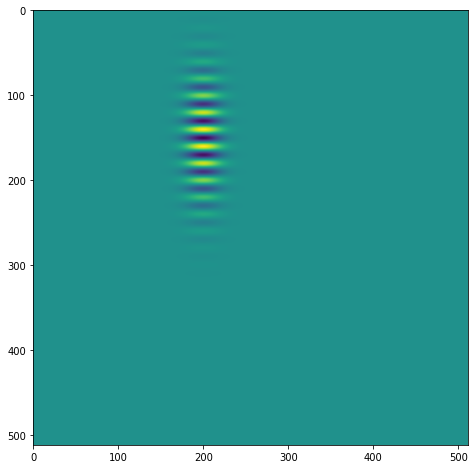

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

fn_wavepacket = make_2d_wavepacket(x0=150, y0=200, lx=100, ly=30, theta=0.0, lw=20)

N = 512
x, y = np.meshgrid(np.arange(N), np.arange(N), indexing="ij")
phi = fn_wavepacket(x, y)

ax.imshow(phi)

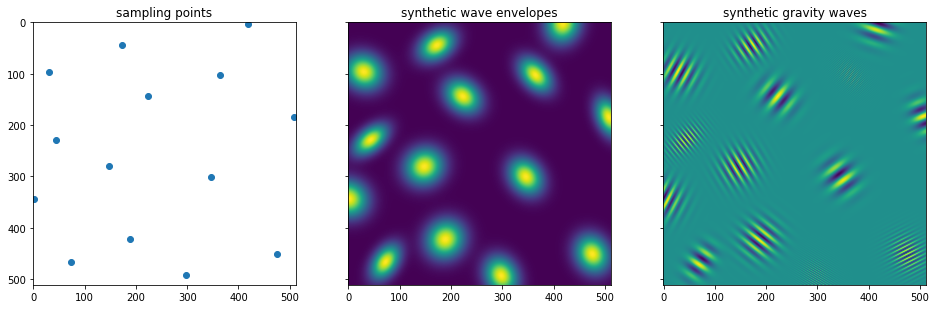

In [8]:
N = 512
x, y = np.meshgrid(np.arange(N), np.arange(N), indexing="xy")

r0 = 100
n_pts, pts, radii = modified_poisson_disk_sampling(N=N, r0=r0, r_sigma=r_sigma)


phi = np.zeros((N, N))
phi_envelope = np.zeros((N, N))

for pt, r in zip(pts, radii):
    theta = 180 * np.random.uniform()
    lw = 20 * np.random.normal()
    a = 0.5 + 0.5 * np.random.uniform()

    lx = r / 2
    ly = a * r / 2
    x0, y0 = pt

    fn_wavepacket = make_2d_wavepacket(x0=x0, y0=y0, lx=lx, ly=ly, theta=theta, lw=lw)
    fn_envelope = make_gaussian_2d(
        x_center=x0, y_center=y0, theta=theta, sigma_x=lx / 2, sigma_y=ly / 2
    )

    phi += fn_wavepacket(x, y)
    phi_envelope += fn_envelope(x, y)


fig, axes = plt.subplots(ncols=3, figsize=(16, 6), sharey=True, sharex=True)
ax = axes[0]
ax.scatter(pts[:, 0], pts[:, 1])
ax.set_title("sampling points")

ax = axes[1]
ax.imshow(phi_envelope)
ax.set_title("synthetic wave envelopes")

ax = axes[2]
ax.imshow(phi)
ax.set_title("synthetic gravity waves")

[ax.set_aspect(1) for ax in axes]

fig.set_facecolor("white")